In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from heteromodes.utils import scale_hmap, load_hmap

In [2]:
hetero_label = "myelinmap"
id = 55
n_params = 1
results_folder = f"{PROJ_DIR}/results/model_rs/{hetero_label}/id-{id}"

In [3]:
# Load results
combs_df = pd.read_csv(f"{PROJ_DIR}/results/model_rs/{hetero_label}/id-{id}/csParamCombs.csv")
combs = combs_df.values
ncombs = len(combs)
combs = combs[combs[:, 1] > 0]

# Reshape results arrays
alpha_vals = np.unique(combs[:, 0])
beta_vals = np.unique(combs[:, 1])
r_vals = np.unique(combs[:, 2])
gamma_vals = np.unique(combs[:, 3])

In [4]:
# Reshape array into alpha x beta x cmean
not_found = 0
if n_params == 1:
    edge_fc, node_fc, fcd = [], [], []

    # Count number of .npz files in folder
    n_files = len([f for f in Path(results_folder).iterdir() if f.is_file() and f.suffix == ".npz"])
    for i in range(n_files):
        results_desc = f"slurmID-{i+1}_output.npz"
        results = np.load(Path(results_folder, results_desc))
        edge_fc.append(np.mean(results['edge_fc']))
        node_fc.append(np.mean(results['node_fc']))
        fcd.append(np.mean(results['fcd']))

    edge_fc = np.array(edge_fc)
    node_fc = np.array(node_fc)
    fcd = np.array(fcd)

elif n_params == 2:
    edge_fc = np.full((len(alpha_vals), len(r_vals)), np.nan)
    node_fc = np.full((len(alpha_vals), len(r_vals)), np.nan)
    fcd = np.full((len(alpha_vals), len(r_vals)), np.nan)

    for i, (alpha, beta, r, gamma) in enumerate(combs):
        # results_desc = f"slurmID-{i+1}_output.npz"
        results_desc = f"hetero-{hetero_label}_alpha-{alpha}_beta-{beta}_r-{r}_gamma-{gamma}_output.npz"
        try:
            results = np.load(Path(results_folder, results_desc))
        except:
            not_found += 1
            continue

        alpha_ind = np.where(alpha_vals == alpha)[0][0]
        r_ind = np.where(r_vals == r)[0][0]

        edge_fc[alpha_ind, r_ind] = np.mean(results['edge_fc'])
        node_fc[alpha_ind, r_ind] = np.mean(results['node_fc'])
        fcd[alpha_ind, r_ind] = np.mean(results['fcd'])

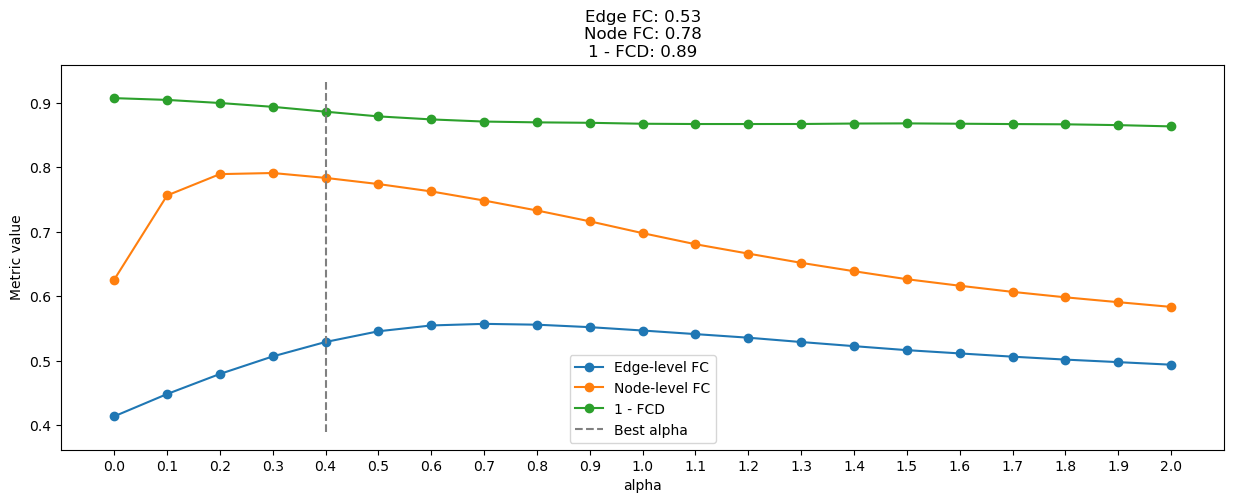

Edge FC: 0.5292721356437492
Node FC: 0.7837781016676468
1 - FCD: 0.8864443611569015


In [5]:
# Plot results (one parameter)
metrics = ["Edge-level FC", "Node-level FC", "1 - FCD"]
combined = edge_fc + node_fc + (1 - fcd)
combined_best = np.nanargmax(combined)

fig = plt.figure(figsize=(15, 5))
plt.plot(edge_fc, label="Edge-level FC", marker="o")
plt.plot(node_fc, label="Node-level FC", marker="o")
plt.plot(1 - fcd, label="1 - FCD", marker="o")

xticks = alpha_vals
plt.gca().set_xticks(np.arange(len(xticks)))
plt.gca().set_xticklabels(xticks)
plt.gca().set_xlabel("alpha")
plt.gca().set_ylabel("Metric value")

# Plot best alpha line
ylims = plt.gca().get_ylim()
plt.vlines(combined_best, ylims[0], ylims[1], colors='gray', linestyles='dashed', label="Best alpha")

# Display best metric values
# plt.gca().set_title(f"Edge FC: {edge_fc[combined_best][0]:.2f}\nNode FC: {node_fc[combined_best][0]:.2f}\n1 - FCD: {1 - fcd[combined_best][0]:.2f}")
plt.gca().set_title(f"Edge FC: {edge_fc[combined_best]:.2f}\nNode FC: {node_fc[combined_best]:.2f}\n1 - FCD: {1 - fcd[combined_best]:.2f}")

plt.legend()
plt.show()

print(f"Edge FC: {edge_fc[combined_best]}")
print(f"Node FC: {node_fc[combined_best]}")
print(f"1 - FCD: {1 - fcd[combined_best]}")

IndexError: Inconsistent shape between the condition and the input (got (21, 1) and (21,))

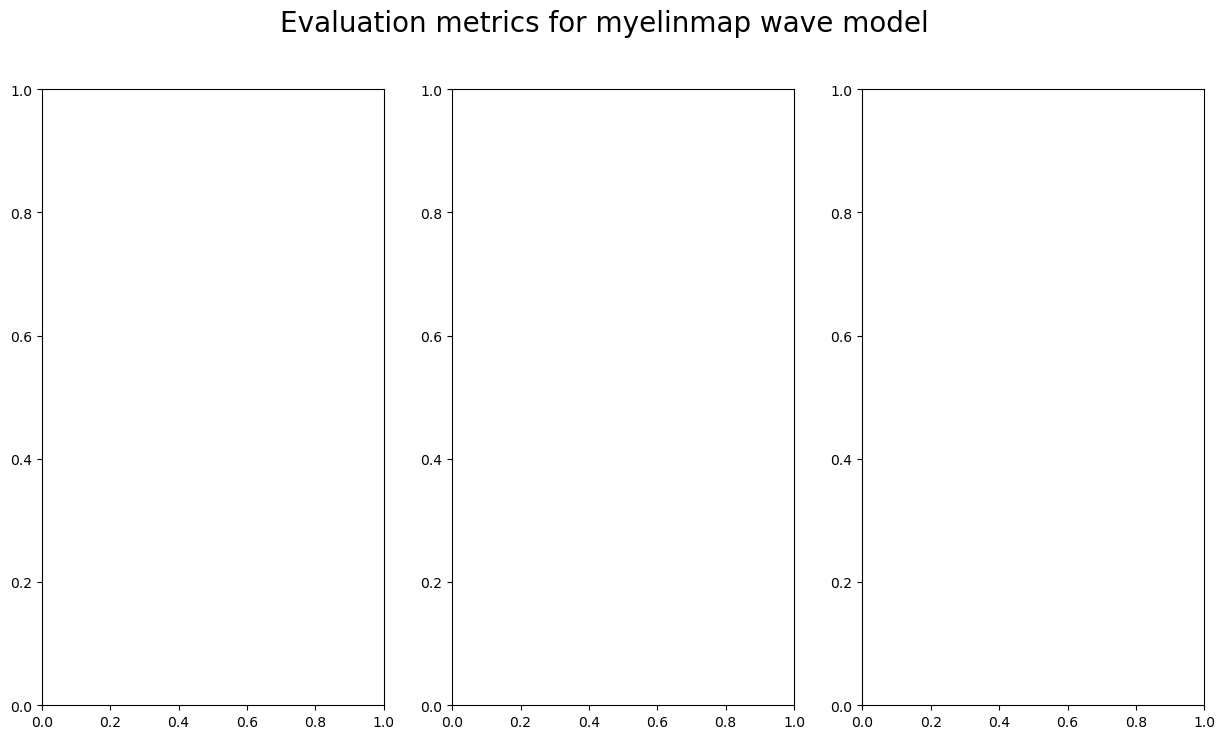

In [6]:
# Plot results (two parameters)
metrics = ["Edge-level FC", "Node-level FC", "1 - FCD"]
combined = edge_fc + node_fc + (1 - fcd)
combined_best = np.unravel_index(np.nanargmax(combined), combined.shape)

# if len(cmean_vals) == 1:
fig, axes = plt.subplots(1, 3, figsize=(15, 8), constrained_layout=False)
fig.suptitle(f"Evaluation metrics for {hetero_label} wave model", fontsize=20)

for i, ax in enumerate(axes):
    # Select data to plot
    if metrics[i] == "Edge-level FC":
        data_to_plot = edge_fc
    elif metrics[i] == "Node-level FC": 
        data_to_plot = node_fc 
    elif metrics[i] ==  "1 - FCD":
        data_to_plot = 1 - fcd
    else:
        None

    # Plot heatmap
    sns.heatmap(data_to_plot, ax=ax, xticklabels=r_vals, yticklabels=alpha_vals, 
                annot=True, fmt=".2f", square=True, annot_kws={"fontsize": 6})
    ax.set_title(metrics[i])
    ax.set_xlabel("r")
    ax.set_ylabel("alpha")
    
    # Draw a red square around the max value in the heatmap
    best = np.unravel_index(np.nanargmax(data_to_plot), data_to_plot.shape)
    rect1 = mpl.patches.Rectangle((best[1], best[0]), 1, 1, linewidth=1, edgecolor='red', facecolor='none')
    ax.add_patch(rect1)

    # Draw a yellow square around the best value based on the combined metric
    rect2 = mpl.patches.Rectangle((combined_best[1], combined_best[0]), 1, 1, linewidth=2.0, edgecolor='yellow', facecolor='none')
    ax.add_patch(rect2)

# else:
    # fig = plt.figure(constrained_layout=True, figsize=(35, 15))
    # fig.suptitle(f"Evaluation metrics for {hetero_label} wave model\nid: {id}", fontsize=20)

    # # Create subfigures for each cmean value
    # subfigs = fig.subfigures(nrows=1, ncols=len(cmean_vals))
    # for i, subfig in enumerate(subfigs):
    #     subfig.suptitle(f"alpha: {cmean_vals[i]}", fontsize=16)

    #     # Create an axis for each metric
    #     axes = subfig.subplots(nrows=3, ncols=1)
    #     for j, ax in enumerate(axes):
    #         # Select data to plot
    #         if metrics[j] == "Edge-level FC":
    #             data_to_plot = edge_fc[:, :, i]
    #         elif metrics[j] == "Node-level FC": 
    #             data_to_plot = node_fc[:, :, i] 
    #         elif metrics[j] ==  "1 - FCD":
    #             data_to_plot = 1 - fcd[:, :, i]
    #         else:
    #             None

    #         # Plot heatmap
    #         sns.heatmap(data_to_plot, ax=ax, xticklabels=beta_vals, yticklabels=alpha_vals, 
    #                     annot=True, fmt=".2f", square=True, annot_kws={"fontsize": 6})
    #         ax.set_title(metrics[j])
    #         ax.set_xlabel("beta")
    #         ax.set_ylabel("alpha")
            
    #         # Draw a red square around the max value in the heatmap
    #         best = np.unravel_index(np.nanargmax(data_to_plot), data_to_plot.shape)
    #         rect1 = mpl.patches.Rectangle((best[1], best[0]), 1, 1, linewidth=2.0, edgecolor='red', facecolor='none')
    #         ax.add_patch(rect1)

    #         # Draw a yellow square around the best value based on the combined metric
    #         rect2 = mpl.patches.Rectangle((combined_best[1], combined_best[0]), 1, 1, linewidth=1, edgecolor='yellow', facecolor='none')
    #         ax.add_patch(rect2)

plt.tight_layout()
plt.show()

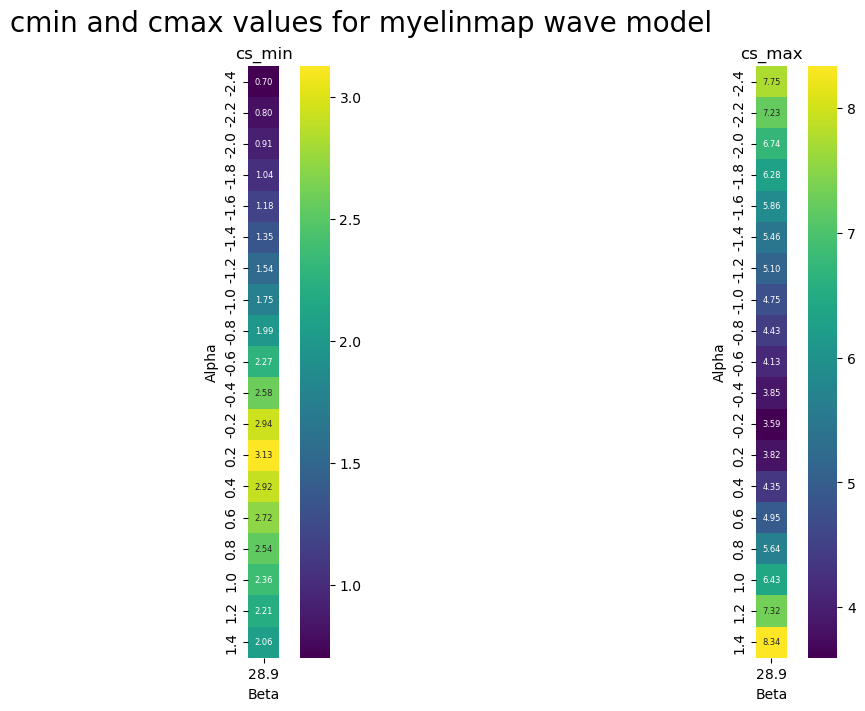

In [ ]:
# Plot wave speed range
medmask = np.loadtxt(MEDMASK_LH).astype(bool)
hetero = load_hmap(hetero_label, medmask=medmask)

# Calculate cmin and cmax values
cs_min = np.full((len(alpha_vals), len(r_vals)), np.nan)
cs_max = np.full((len(alpha_vals), len(r_vals)), np.nan)
for i, (alpha, beta, r, gamma) in enumerate(combs):
    alpha_ind = np.where(alpha_vals == alpha)[0][0]
    r_ind = np.where(r_vals == r)[0][0]

    rho = scale_hmap(hetero, alpha, beta, r, gamma, method="norm", verbose=False)
    cs_min[alpha_ind, r_ind] = np.min(rho) * r * gamma
    cs_max[alpha_ind, r_ind] = np.max(rho) * r * gamma

# Plot cmin and cmax values
# if len(cmean_vals) == 1:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 7))
plt.suptitle(f"cmin and cmax values for {hetero_label} wave model", fontsize=20)

sns.heatmap(cs_min, ax=axs[0], xticklabels=r_vals, yticklabels=alpha_vals,
            annot=True, fmt=".2f", square=True, annot_kws={"fontsize": 6}, cmap="viridis")
axs[0].set_title("cs_min")
axs[0].set_xlabel("Beta")
axs[0].set_ylabel("Alpha")

sns.heatmap(cs_max, ax=axs[1], xticklabels=r_vals, yticklabels=alpha_vals,
            annot=True, fmt=".2f", square=True, annot_kws={"fontsize": 6}, cmap="viridis")
axs[1].set_title("cs_max")
axs[1].set_xlabel("Beta")
axs[1].set_ylabel("Alpha")
# else:
#     fig = plt.figure(figsize=(35, 15), constrained_layout=True)
#     fig.suptitle(f"cmin and cmax values for {hetero_label} wave model", fontsize=20)

#     # Create subfigures for each cmean value
#     subfigs = fig.subfigures(nrows=1, ncols=len(cmean_vals))
#     for i, subfig in enumerate(subfigs):
#         subfig.suptitle(f"cmean: {cmean_vals[i]}", fontsize=16)

#         # Create an axis for each metric
#         axes = subfig.subplots(nrows=2, ncols=1)
#         sns.heatmap(cs_min[:, :, i], ax=axes[0], xticklabels=beta_vals, yticklabels=alpha_vals,
#                     annot=True, fmt=".2f", square=True, annot_kws={"fontsize": 6}, cmap="viridis")
#         axes[0].set_title("cs_min")
#         axes[0].set_xlabel("Beta")
#         axes[0].set_ylabel("Alpha")

#         sns.heatmap(cs_max[:, :, i], ax=axes[1], xticklabels=beta_vals, yticklabels=alpha_vals,
#                     annot=True, fmt=".2f", square=True, annot_kws={"fontsize": 6}, cmap="viridis")
#         axes[1].set_title("cs_max")
#         axes[1].set_xlabel("Beta")
#         axes[1].set_ylabel("Alpha")

plt.show()

In [ ]:
# Plot comparison of evaluation metrics with homogeneous model
homo_results = np.load(f"{PROJ_DIR}/results/model_rs/None/id-1/hetero-None_alpha-1.0_beta-1.0_cmean-3.3524_saveAll.npz")
print(homo_results.keys())

FileNotFoundError: [Errno 2] No such file or directory: '/fs04/kg98/vbarnes/HeteroModes/results/model_rs/None/id-1/hetero-None_alpha-1.0_beta-1.0_cmean-3.3524_saveAll.npz'

In [ ]:
# import plotly.graph_objects as go
# import numpy as np
# import seaborn as sns

# # Assuming you have a 3D array Z for the values
# Z = edge_fc + node_fc + (1 - fcd)

# # Create x, y, and z coordinates
# x, y, z = np.meshgrid(alpha_vals, beta_vals, cmean_vals, indexing='ij')

# fig = go.Figure(data=[go.Scatter3d(
#     x=x.flatten(),
#     y=y.flatten(),
#     z=z.flatten(),
#     mode='markers',
#     marker=dict(
#         size=4,
#         color=Z.flatten(),  # set color to an array/list of desired values
#         colorscale="viridis",  # choose a colorscale
#         opacity=0.8,
#         colorbar=dict(title='Edge-level FC')
#     )
# )])

# fig.update_layout(
#     width=800,  # Set the width of the figure
#     height=600,  # Set the height of the figure
#     margin=dict(l=0, r=0, b=0, t=0),
#     scene=dict(
#         xaxis_title='Alpha',
#         yaxis_title='Beta',
#         zaxis_title='Cmean'
#     )
# )

# fig.show()